In [ ]:
# Import Library
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
# Import datasets and pretrained model
!mkdir /dataset

!mkdir /pretrained_model

!wget --no-check-certificate \
    https://github.com/felixlaynardi/road-classification/raw/main/dataset/dt.zip \
    -O /dataset/dt.zip

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /pretrained_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Extract datasets
zip_path = '/dataset/dt.zip'
ref = zipfile.ZipFile(zip_path, 'r')
ref.extractall('/dataset')
ref.close()

--2021-06-02 13:25:59--  https://github.com/felixlaynardi/road-classification/raw/main/dataset/dt.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/felixlaynardi/road-classification/main/dataset/dt.zip [following]
--2021-06-02 13:25:59--  https://raw.githubusercontent.com/felixlaynardi/road-classification/main/dataset/dt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74799089 (71M) [application/zip]
Saving to: ‘/dataset/dt.zip’

/dataset/dt.zip     100%[===================>]  71.33M   127MB/s    in 0.6s    

2021-06-02 13:26:03 (127 MB/s) - ‘/dataset/dt.zip’ saved [74799089/74799089]

--2

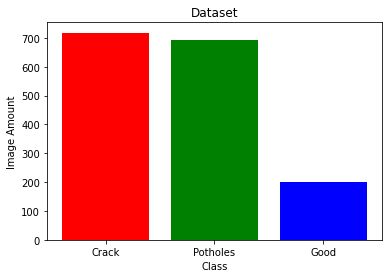

In [ ]:
# Get dataset size on graph
 
left = [1, 2, 3]
height = [len(os.listdir('/dataset/Crack')), len(os.listdir('/dataset/Pothole')), len(os.listdir('/dataset/Good'))]
  
tick_label = ['Crack', 'Potholes', 'Good']
  
plt.bar(left, height, tick_label = tick_label, width = 0.8, color = ['red', 'green', 'blue'])
  
plt.xlabel('Class')
plt.ylabel('Image Amount')
plt.title('Dataset')

plt.show()

In [ ]:
# Put datasets into list for splitting training and test set
data_dir = '/dataset'

labels = ["Crack", "Pothole", "Good"]
x = []
y = []

# Read and resize image
for label in labels:
    data = os.path.join(data_dir,label)
    for image in os.listdir(data):
        try:
            im = cv2.imread(os.path.join(data,image),cv2.IMREAD_COLOR)
            im = cv2.resize(im,(224,224))
            
            x.append(im)
            y.append(labels.index(label))
            
            
        except Exception as e:
            pass

In [ ]:
# Get size of data and labels
len(x)

1610

In [ ]:
len(y)

1610

In [ ]:
# Put list of datasets into numpy
np.unique(y)
np.unique(x)

x = np.array(x)/255.0
y = np.array(y)

x.shape
y.shape

# Reshape numpy array
x = x.reshape(-1, 224, 224, 3)
x.shape
y = y.reshape(-1, 1)

In [ ]:
# Set y into one hot encoding
y = to_categorical(y,3,)

# Data augmentation
datagenerator = ImageDataGenerator(
  fill_mode= 'nearest',
  horizontal_flip=False,
  vertical_flip=False,
  shear_range=0.1,
  zoom_range = 0.1,
  width_shift_range=0.2,
  height_shift_range=0.2
)
datagenerator.fit(x)

In [ ]:
# Split dataset into train and test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [ ]:
path_inception = f"/pretrained_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None
)
pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
# pre_trained_model.summary()


In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x) 

model = Model(pre_trained_model.input, x) 

# Set RMSProp optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
# Set training callback
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

# Train model in .. epochs
model.fit(datagenerator.flow(x_train, y_train, batch_size=32,shuffle=True), epochs=20, validation_data=datagenerator.flow(x_test, y_test))

Epoch 1/20
38/38 [==============================] - 57s 685ms/step - loss: 1.0541 - accuracy: 0.7871 - val_loss: 0.1633 - val_accuracy: 0.9504
Epoch 2/20
38/38 [==============================] - 22s 583ms/step - loss: 0.2141 - accuracy: 0.9155 - val_loss: 0.1635 - val_accuracy: 0.9355
Epoch 3/20
38/38 [==============================] - 22s 584ms/step - loss: 0.1148 - accuracy: 0.9594 - val_loss: 0.1380 - val_accuracy: 0.9454
Epoch 4/20
38/38 [==============================] - 22s 584ms/step - loss: 0.1482 - accuracy: 0.9486 - val_loss: 0.0545 - val_accuracy: 0.9752
Epoch 5/20
38/38 [==============================] - 22s 586ms/step - loss: 0.1397 - accuracy: 0.9586 - val_loss: 0.0544 - val_accuracy: 0.9727
Epoch 6/20
38/38 [==============================] - 22s 589ms/step - loss: 0.0982 - accuracy: 0.9693 - val_loss: 0.0467 - val_accuracy: 0.9752
Epoch 7/20
38/38 [==============================] - 22s 586ms/step - loss: 0.0836 - accuracy: 0.9751 - val_loss: 0.0270 - val_accuracy: 0.9901

In [ ]:
# Convert inputted image into array
from PIL import Image
def convert_to_array(img):
    im = cv2.imread(img)
    img = Image.fromarray(im, 'RGB')
    image = img.resize((224, 224))
    return np.array(image)

# Set label into Crack and Pothole
def get_profile_name(label):
    if label==0:
        return "Crack"
    if label==1:
        return "Pothole"
    if label==2:
        return "Good"

# Predict function
def predict_profile(file):
    print("Predicting .................................")
    ar = convert_to_array(file)
    ar = ar/255
    a = []
    a.append(ar)
    a = np.array(a)
    score = model.predict(a,verbose=1)
    print(score)
    label_index = np.argmax(score)
    print(label_index)
    acc = np.max(score)
    profile = get_profile_name(label_index)
    print(profile)
    print("The predicted profile is a " + profile + " with accuracy =    " + str(acc))  

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  predict_profile(path)
  # img = image.load_img(path, target_size=(224, 224))
  # x = image.img_to_array(img)
  # x = np.expand_dims(x, axis=0)

  # images = np.vstack([x])
  # classes = model.predict(images, batch_size=10)
  # print(fn)
  
  # print(classes[0])

Saving 77747.jpg to 77747.jpg
Predicting .................................
1/1 [==============================] - 2s 2s/step
[[7.9498726e-01 2.0501269e-01 4.3668502e-17]]
0
Crack
The predicted profile is a Crack with accuracy =    0.79498726


In [ ]:
model.save('pothole_classification.h5')